In [196]:
import pandas as pd
import numpy as np

df= pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [197]:
print(df.shape)
df.info()
df.describe()
null_values = df.isnull().sum()
print(null_values)

(1338, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


No null missing values

In [198]:
from sklearn.ensemble import RandomForestRegressor
print("Training before cleaning data")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.metrics import mean_squared_error, r2_score

dfencoded=pd.get_dummies(df,drop_first=True,dtype='int64')

x=dfencoded.drop("charges", axis=1)
y=dfencoded["charges"]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
model=LinearRegression()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print("MSE OF LINEAR:",mean_squared_error(y_test,y_pred))
print("R2 OF LINEAR:",r2_score(y_test,y_pred))

model=Lasso()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print("MSE OF LASSO:",mean_squared_error(y_test,y_pred))
print("R2 OF LASSO:",r2_score(y_test,y_pred))

model=Ridge()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print("MSE OF RIDGE:",mean_squared_error(y_test,y_pred))    
print("R2 OF RIDGE:",r2_score(y_test,y_pred))

model=RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("MSE OF RANDOM FOREST:", mean_squared_error(y_test, y_pred))
print("R2 OF RANDOM FOREST:", r2_score(y_test, y_pred))

Training before cleaning data
MSE OF LINEAR: 33596915.85136146
R2 OF LINEAR: 0.7835929767120723
MSE OF LASSO: 33605507.55392852
R2 OF LASSO: 0.7835376351805539
MSE OF RIDGE: 33645037.09177904
R2 OF RIDGE: 0.7832830144988214
MSE OF RANDOM FOREST: 21132913.614413716
R2 OF RANDOM FOREST: 0.8638770609501982


In [199]:
print("Cleaning")
numeric=df.select_dtypes(include=['int64','float64']).columns
for col in numeric:
    median=df[col].median()
    df[col]=df[col].fillna(median)
    print(f"Filled {col} with median:{median}")
categorical=df.select_dtypes(include=['object']).columns
for col in categorical: 
    mode = df[col].mode()[0]
    df[col]=df[col].fillna(mode)
    print(f"Filled {col} with mode:{mode}")

Cleaning
Filled age with median:39.0
Filled bmi with median:30.4
Filled children with median:1.0
Filled charges with median:9382.033
Filled sex with mode:male
Filled smoker with mode:no
Filled region with mode:southeast


EDA and feature selection
age                 1.503338
smoker_yes          0.369171
sex_male            0.176660
children            0.160860
bmi                 0.072554
region_northwest    0.057682
region_southeast    0.035070
region_southwest    0.002621
dtype: float64


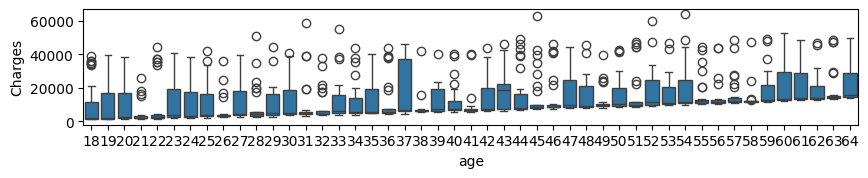

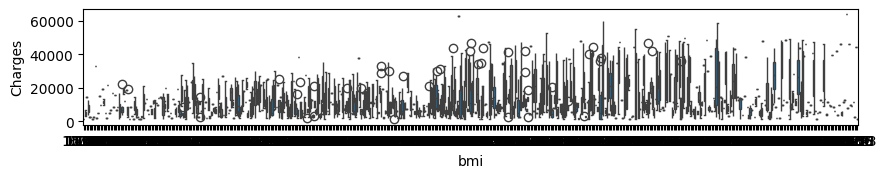

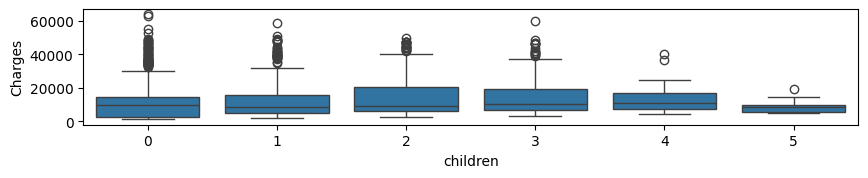

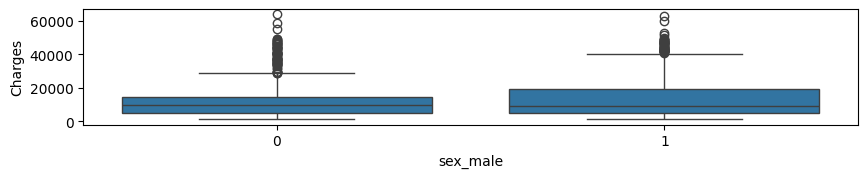

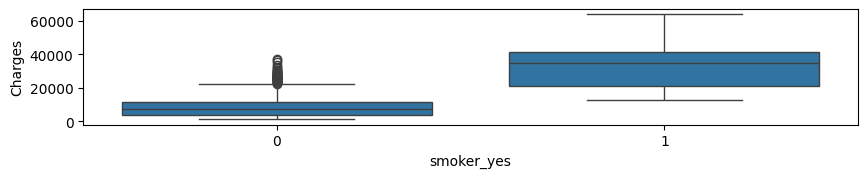

In [200]:
print("EDA and feature selection")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
target=df['charges']
dfprocessed=pd.get_dummies(df.drop('charges',axis=1),drop_first=True,dtype=int)
mi=mutual_info_regression(dfprocessed,target)
miscore=pd.Series(mi,index=dfprocessed.columns).sort_values(ascending=False)
print(miscore)

features=dfprocessed.columns[mi>0.06]
for feature in features:
    plt.figure(figsize=(10,1.5))
    sns.boxplot(x=dfprocessed[feature],y=target)
    plt.xlabel(feature)
    plt.ylabel('Charges')
    plt.show()



In [201]:
print("cleaning outliers")

dftoclean=pd.concat([dfprocessed,target],axis=1)
def remove_outliers(dftoclean, col):
    Q1=dftoclean[col].quantile(0.25)
    Q3=dftoclean[col].quantile(0.75)
    IQR=Q3-Q1
    lower=Q1-1.5*IQR
    upper=Q3+1.5*IQR
    print(f"Values outside bounds(checking):{(dftoclean[feature]<lower).sum()+(dftoclean[feature]>upper).sum()}")
    return dftoclean[(dftoclean[col]>=lower)&(dftoclean[col]<=upper)]
    
for feature in ['age','bmi','children']:
    rows_before=len(dftoclean)
    dftoclean=remove_outliers(dftoclean, feature)
    rows_after=len(dftoclean)
    print(f"Removed {rows_before-rows_after} outliers from {feature}")



cleaning outliers
Values outside bounds(checking):0
Removed 0 outliers from age
Values outside bounds(checking):9
Removed 9 outliers from bmi
Values outside bounds(checking):0
Removed 0 outliers from children


In [202]:
print("Model after cleaning outliers")
dfencoded=dftoclean.copy()

x=dfencoded.drop("charges", axis=1)
y=dfencoded["charges"]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
model=LinearRegression()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print("MSE OF LINEAR:",mean_squared_error(y_test,y_pred))
print("R2 OF LINEAR:",r2_score(y_test,y_pred))

model=Lasso()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print("MSE OF LASSO:",mean_squared_error(y_test,y_pred))
print("R2 OF LASSO:",r2_score(y_test,y_pred))

model=Ridge()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print("MSE OF RIDGE:",mean_squared_error(y_test,y_pred))    
print("R2 OF RIDGE:",r2_score(y_test,y_pred))

model=RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("MSE OF RANDOM FOREST:", mean_squared_error(y_test, y_pred))
print("R2 OF RANDOM FOREST:", r2_score(y_test, y_pred))

Model after cleaning outliers
MSE OF LINEAR: 34498730.946864136
R2 OF LINEAR: 0.7671119511350497
MSE OF LASSO: 34492526.516190596
R2 OF LASSO: 0.767153834929445
MSE OF RIDGE: 34493581.37546374
R2 OF RIDGE: 0.7671467139684356
MSE OF RANDOM FOREST: 24867297.001484532
R2 OF RANDOM FOREST: 0.8321301647837172


In [203]:
from sklearn.ensemble import RandomForestRegressor

classfier=RandomForestRegressor(n_estimators=300, max_depth=15, random_state=42)
random_forest=classfier.fit(x,y)
print("Feature importance from random forest:")
feature_import=random_forest.feature_importances_
feature_importance=pd.Series(feature_import,index=x.columns).sort_values(ascending=False)
print(feature_importance)

featuresselected=feature_importance[feature_importance>feature_importance.mean()].index.tolist()
print(featuresselected)

Feature importance from random forest:
smoker_yes          0.616513
bmi                 0.211044
age                 0.132126
children            0.019010
region_northwest    0.006188
sex_male            0.005773
region_southeast    0.005032
region_southwest    0.004314
dtype: float64
['smoker_yes', 'bmi', 'age']


In [204]:
print("Training after cleaning data and feature selection")
x=x[featuresselected]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

model=LinearRegression()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print("MSE OF LINEAR:",mean_squared_error(y_test,y_pred))
print("R2 OF LINEAR:",r2_score(y_test,y_pred))

model=Lasso()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print("MSE OF LASSO:",mean_squared_error(y_test,y_pred))
print("R2 OF LASSO:",r2_score(y_test,y_pred))
model=Ridge()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print("MSE OF RIDGE:",mean_squared_error(y_test,y_pred))
print("R2 OF RIDGE:",r2_score(y_test,y_pred))

model=RandomForestRegressor(n_estimators=300, max_depth=15, random_state=42)
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print("R2 OF RANDOM FOREST:",r2_score(y_test,y_pred))

Training after cleaning data and feature selection
MSE OF LINEAR: 34424183.81556811
R2 OF LINEAR: 0.7676151909783573
MSE OF LASSO: 34424507.9453626
R2 OF LASSO: 0.7676130028991629
MSE OF RIDGE: 34431928.93903396
R2 OF RIDGE: 0.767562906542302
R2 OF RANDOM FOREST: 0.8342717207169065
